In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# fitness function
def fitness_val(der_ale,A,zP1,O):
    z_i = zP1 + np.matmul(A,der_ale)
    z_sq = np.square(z_i-O)
    w = np.ravel(np.exp(-np.sum(z_sq,axis=0))) #np.ravel to flatten matrix into a 1D array
    #log_w = np.log(w)
    return w

In [3]:
# hybridisation simulation with chance of choosing parent proportional to their fitness
def hybridisation_proportional_fitness(P1,P2,N,A,zP1,O,seedValue):
    rng = np.random.default_rng(seedValue)
    t = 1 #number of generations
    D = P1.shape[0]
    P1 = np.matrix(P1); P2 = np.matrix(P2)
    P1_fit = fitness_val(P1,A,zP1,O)
    P1_choice = np.random.choice(range(N),N,replace=True,p=(P1_fit)/sum(P1_fit))
    S1 = np.zeros([D,1])
    for i in P1_choice:
        s = P1[:,i]
        S1 = np.concatenate((S1,s),axis=1)
    S1 = np.delete(S1,0,1)
    P2_fit = fitness_val(P2,A,zP1,O)
    P2_choice = np.random.choice(range(N),N,replace=True,p=(P2_fit)/sum(P2_fit))
    # sample from the new population with replacement
    S2 = np.zeros([D,1])
    for i in P2_choice:
        s = P2[:,i]
        S2 = np.concatenate((S2,s),axis=1)
    S2 = np.delete(S2,0,1)

    np.place(S1,S1 == 1,rng.binomial(1,0.5,[D,N])*2)
    np.place(S2,S2 == 1,rng.binomial(1,0.5,[D,N])*2)
    F = np.matrix((S1 + S2)/2)

    while 1 in F:
        # sample two parental populations from the new population with replacement. Probability proportional to fitness
        F_fit_1 = fitness_val(F,A,zP1,O)
        P1_choice = np.random.choice(range(N),N,replace=True,p=(F_fit_1)/sum(F_fit_1))
        S1 = np.zeros([D,1])
        for i in P1_choice:
            s = F[:,i]
            S1 = np.concatenate((S1,s),axis=1)
        S1 = np.delete(S1,0,1)
        F_fit_2 = fitness_val(F,A,zP1,O)
        P2_choice = np.random.choice(range(N),N,replace=True,p=(F_fit_2)/sum(F_fit_2))
        # sample from the new population with replacement
        S2 = np.zeros([D,1])
        for i in P2_choice:
            s = F[:,i]
            S2 = np.concatenate((S2,s),axis=1)
        S2 = np.delete(S2,0,1)
        # a new hybridisation
        np.place(S1,S1 == 1,rng.binomial(1,0.5,[D,N])*2)
        np.place(S2,S2 == 1,rng.binomial(1,0.5,[D,N])*2)
        F = (S1 + S2)/2
        t += 1
        #print(f"F {G}")
        #print(F)
    H = np.mean(F)/2
    F_log_fit = np.log(fitness_val(F,A,zP1,O)[0])
    return F, t, H, F_log_fit

# Simulating hybridisation in the background of evolutionary divergence

Random mutation model. Each of the two hybridising populations have acquired mutations that affect traits by coefficients that follow a normal distribution.

P1 and P2 have each fixed random mutations at D/2 sites. Each mutation affects each of the n traits of an individual by a coefficient that is normally distributed. For comparison between scenarios, we fix the value of selection coefficient of each individual mutations, $s_i$.

Details on fixing $s_i$:

For any particular locus $i$, the selection coefficient is
$$
s_{i}\approx -4\sum_{j=1}^{n}a_{ij}^2
$$
For scaling, we set the scaling factor $r$ as
$$
4r^{2} = -s_{i}
$$
Selection is effective when $N|s|>1$. (need support)

In [4]:
# a function to normalise and then scale them
def scaling(r,a,D,n):
    # calculate the magnitude of rows in the random number matrix a
    a_square = np.square(a)
    a_row_mag = np.sqrt(np.sum(a_square,axis=1))
    # scale each row by its magnitude
    mag_matx = np.reshape(np.repeat(a_row_mag,repeats=n,axis=0),newshape=[D,n])
    #print(mag_matx)
    unit_matx = np.divide(a,mag_matx)
    # rescale it to have a magnitude of r^2
    A = r*unit_matx
    return A

Let us arrange the gene loci of all the mutation such that the ones fixed in P1 come first. In this case, the individual trait values for a P1 individual will be:
$$
z_{P1,j} = 2\sum_{i=1}^{D/2}m_{ij}
$$

The ancestral phenotype do not carry any of the mutations in P1 or P2. Therefore, the ancestral genotype will have the P2 genotype at loci where P1 has fixed a mutation and the P1 genotype at loci where P2 has fixed a mutation. Its phenotype would give the optimum fitness.

# Using a stronger selection coefficient

# Random mutation

In [5]:

rng = np.random.default_rng(seed=214)

n = 10; D = 10; N = 500
#choose scaling factor so that N*|s|~5
sN_target = 0.5
r = np.sqrt(sN_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| ～ {4*r**2*N}")

D_h = int(D/2)
# generate normally distributed random numbers for mutations. m for P1 and l for P2. Standard normal distribution.
m = rng.normal(loc=0,scale=1,size=[D_h,n])
l = rng.normal(loc=0,scale=1,size=[D_h,n])
M = scaling(r,m,D_h,n)
L = scaling(r,l,D_h,n)

zP1_vec = 2*np.sum(M,axis=0)
zP1 = np.reshape(np.repeat(zP1_vec,repeats=N,axis=0),newshape=[n,N])

A = np.concatenate((-1*M,L),axis=0)

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)
P1_log_fit = np.log(fitness_val(P1,A.T,zP1,O))
P2_log_fit = np.log(fitness_val(P2,A.T,zP1,O))
print(f"log fitness of P1 is {P1_log_fit[0]}")
print(f"log fitness of P2 is {P2_log_fit[0]}")

repeats = 10
t = []; H = []; lgfit = []
for k in range(1,repeats+1):
    print('')
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    #print(f"final population {w[0]}")
    t.append(w[1])
    H.append(w[2])
    lgfit.append(w[3])
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")
print(f't{t}\nH{H}\nlgfit {lgfit}')
t_si05_ran500 = t
H_si05_ran500 = H
lgfit_si05_ran500 = lgfit

r = 0.015811388300841896
target s_i =-0.0009999999999999998
target N|s_i| ～ 0.4999999999999999
log fitness of P1 is -0.009267494341431782
log fitness of P2 is -0.005155542641588749

Simulation 1
no. of generations to fixation 1724
hybridisation index (H)0.5
log fitness of final population -0.0028594539419969454

Simulation 2
no. of generations to fixation 4557
hybridisation index (H)0.5
log fitness of final population -0.0012648181381615126

Simulation 3
no. of generations to fixation 2180
hybridisation index (H)0.6
log fitness of final population -0.0030519542144999403

Simulation 4
no. of generations to fixation 4256
hybridisation index (H)0.5
log fitness of final population -0.0044035033349595284

Simulation 5
no. of generations to fixation 3839
hybridisation index (H)0.4
log fitness of final population -0.0009999999999999697

Simulation 6
no. of generations to fixation 4945
hybridisation index (H)0.6
log fitness of final population -0.0009999999999999697

Simulation 7
no. of genera

In [6]:
# the above example should be repeated with a stronger selection coefficient to see quasi-deterministic effect
rng = np.random.default_rng(seed=214)

n = 10; D = 10; N = 500
#choose scaling factor so that N*|s|~5
sN_target = 2
r = np.sqrt(sN_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")

D_h = int(D/2)
# generate normally distributed random numbers for mutations. m for P1 and l for P2. Standard normal distribution.
m = rng.normal(loc=0,scale=1,size=[D_h,n])
l = rng.normal(loc=0,scale=1,size=[D_h,n])

M = scaling(r,m,D_h,n)
L = scaling(r,l,D_h,n)

zP1_vec = 2*np.sum(M,axis=0)
#print(zP1_vec)
zP1 = np.reshape(np.repeat(zP1_vec,repeats=N,axis=0),newshape=[n,N])
#print(zP1.shape)

A = np.concatenate((-1*M,L),axis=0)
#print(f"A\n{A}")
#print(A.shape)

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)
P1_log_fit = np.log(fitness_val(P1,A.T,zP1,O))
P2_log_fit = np.log(fitness_val(P2,A.T,zP1,O))
print(f"log fitness of P1 is {P1_log_fit[0]}")
print(f"log fitness of P2 is {P2_log_fit[0]}")

repeats = 10
t = []; H = []; lgfit = []
for k in range(1,repeats+1):

    print('')
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    t.append(w[1])
    H.append(w[2])
    lgfit.append(w[3])
    #print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")
print(f't{t}\nH{H}\nlgfit {lgfit}')
t_si2_ran500 = t
H_si2_ran500 = H
lgfit_si2_ran500 = lgfit

r = 0.03162277660168379
target s_i =-0.003999999999999999
target N|s_i| = 1.9999999999999996
log fitness of P1 is -0.037069977365727154
log fitness of P2 is -0.02062217056635494

Simulation 1
no. of generations to fixation 8390
hybridisation index (H)0.7
log fitness of final population -0.007274657147784844

Simulation 2
no. of generations to fixation 2636
hybridisation index (H)0.6
log fitness of final population -0.003999999999999988

Simulation 3
no. of generations to fixation 2511
hybridisation index (H)0.5
log fitness of final population -0.007749639339074862

Simulation 4
no. of generations to fixation 3141
hybridisation index (H)0.5
log fitness of final population -0.005046223686963378

Simulation 5
no. of generations to fixation 2763
hybridisation index (H)0.7
log fitness of final population -0.005965368318569095

Simulation 6
no. of generations to fixation 2282
hybridisation index (H)0.4
log fitness of final population -0.00794162672237813

Simulation 7
no. of generations to f

In [7]:
# the above example should be repeated with a stronger selection coefficient to see quasi-deterministic effect
rng = np.random.default_rng(seed=214)

n = 10; D = 10; N = 500
#choose scaling factor so that N*|s|~5
sN_target = 5
r = np.sqrt(sN_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")

D_h = int(D/2)
# generate normally distributed random numbers for mutations. m for P1 and l for P2. Standard normal distribution.
m = rng.normal(loc=0,scale=1,size=[D_h,n])
l = rng.normal(loc=0,scale=1,size=[D_h,n])

M = scaling(r,m,D_h,n)
L = scaling(r,l,D_h,n)

zP1_vec = 2*np.sum(M,axis=0)
#print(zP1_vec)
zP1 = np.reshape(np.repeat(zP1_vec,repeats=N,axis=0),newshape=[n,N])
#print(zP1.shape)

A = np.concatenate((-1*M,L),axis=0)
#print(f"A\n{A}")
#print(A.shape)

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)
P1_log_fit = np.log(fitness_val(P1,A.T,zP1,O))
P2_log_fit = np.log(fitness_val(P2,A.T,zP1,O))
print(f"log fitness of P1 is {P1_log_fit[0]}")
print(f"log fitness of P2 is {P2_log_fit[0]}")

repeats = 10
t = []; H = []; lgfit = []
for k in range(1,repeats+1):

    print('')
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    t.append(w[1])
    H.append(w[2])
    lgfit.append(w[3])
    #print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")
print(f't{t}\nH{H}\nlgfit {lgfit}')
t_si5_ran500 = t
H_si5_ran500 = H
lgfit_si5_ran500 = lgfit

r = 0.05
target s_i =-0.010000000000000002
target N|s_i| = 5.000000000000001
log fitness of P1 is -0.0926749434143179
log fitness of P2 is -0.051555426415887395

Simulation 1
no. of generations to fixation 1996
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 2
no. of generations to fixation 1779
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 3
no. of generations to fixation 1991
hybridisation index (H)0.5
log fitness of final population -0.00612541271995287

Simulation 4
no. of generations to fixation 1721
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 5
no. of generations to fixation 1312
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 6
no. of generations to fixation 2794
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 7
no. of generations to fixation 1726
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 8
no. of generation

In [8]:
# the above example should be repeated with a stronger selection coefficient to see quasi-deterministic effect
rng = np.random.default_rng(seed=214)

n = 10; D = 10; N = 500
#choose scaling factor so that N*|s|~5
s_i_target = 10
r = np.sqrt(s_i_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")

D_h = int(D/2)
# generate normally distributed random numbers for mutations. m for P1 and l for P2. Standard normal distribution.
m = rng.normal(loc=0,scale=1,size=[D_h,n])
l = rng.normal(loc=0,scale=1,size=[D_h,n])

M = scaling(r,m,D_h,n)
L = scaling(r,l,D_h,n)

zP1_vec = 2*np.sum(M,axis=0)
#print(zP1_vec)
zP1 = np.reshape(np.repeat(zP1_vec,repeats=N,axis=0),newshape=[n,N])
#print(zP1.shape)

A = np.concatenate((-1*M,L),axis=0)
#print(f"A\n{A}")
#print(A.shape)

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)
P1_log_fit = np.log(fitness_val(P1,A.T,zP1,O))
P2_log_fit = np.log(fitness_val(P2,A.T,zP1,O))
print(f"log fitness of P1 is {P1_log_fit[0]}")
print(f"log fitness of P2 is {P2_log_fit[0]}")

repeats = 10
t = []; H = []; lgfit = []
for k in range(1,repeats+1):
    print('')
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    t.append(w[1])
    H.append(w[2])
    lgfit.append(w[3])
    #print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")
print(f't{t}\nH{H}\nlgfit {lgfit}')
t_si10_ran500 = t
H_si10_ran500 = H
lgfit_si10_ran500 = lgfit

r = 0.07071067811865475
target s_i =-0.02
target N|s_i| = 10.0
log fitness of P1 is -0.18534988682863582
log fitness of P2 is -0.10311085283177478

Simulation 1
no. of generations to fixation 1197
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 2
no. of generations to fixation 1094
hybridisation index (H)0.5
log fitness of final population -0.012250825439905693

Simulation 3
no. of generations to fixation 2452
hybridisation index (H)0.6
log fitness of final population -0.008928463376898987

Simulation 4
no. of generations to fixation 728
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 5
no. of generations to fixation 881
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 6
no. of generations to fixation 661
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 7
no. of generations to fixation 1092
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 8
no. of generati

In [9]:
#plots
Ns = [0.5,2,5,10]
t_ran500 = [np.mean(t_si05_ran500),np.mean(t_si2_ran500),np.mean(t_si5_ran500),np.mean(t_si10_ran500)]
t_err_ran500 = [np.std(t_si05_ran500),np.std(t_si2_ran500),np.std(t_si5_ran500),np.std(t_si10_ran500)]
lgfit_ran500 = [np.mean(lgfit_si05_ran500),np.mean(lgfit_si2_ran500),np.mean(lgfit_si5_ran500),np.mean(lgfit_si10_ran500)]
lgfit_err_ran500 = [np.std(lgfit_si05_ran500),np.std(lgfit_si2_ran500),np.std(lgfit_si5_ran500),np.std(lgfit_si10_ran500)]

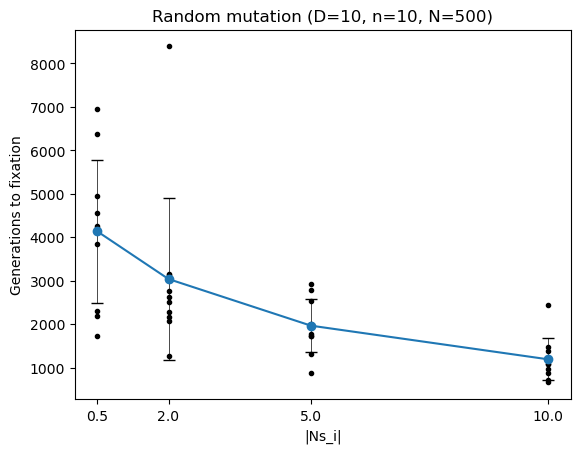

In [10]:
plt.errorbar(Ns,t_ran500,yerr=t_err_ran500,fmt='o-',ecolor='k',elinewidth=0.5, capsize=4)
plt.plot(Ns,[t_si05_ran500,t_si2_ran500,t_si5_ran500,t_si10_ran500],'ko',ms=3)
plt.title('Random mutation (D=10, n=10, N=500)')
plt.xlabel('|Ns_i|')
plt.ylabel('Generations to fixation')
plt.xticks(Ns)
plt.show()

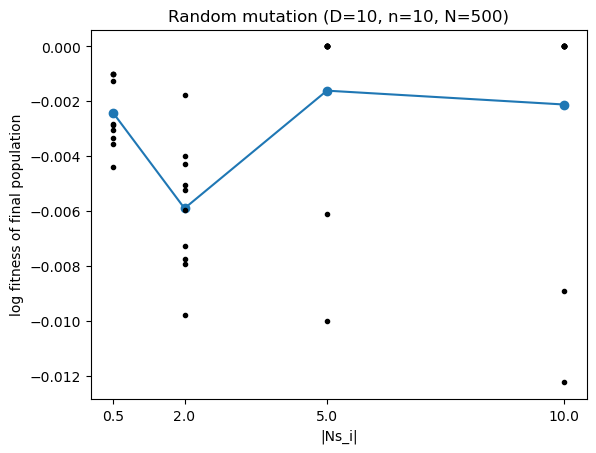

In [11]:
plt.plot(Ns,lgfit_ran500,'o-')
plt.plot(Ns,[lgfit_si05_ran500,lgfit_si2_ran500,lgfit_si5_ran500,lgfit_si10_ran500],'ko',ms=3)
plt.title('Random mutation (D=10, n=10, N=500)')
plt.xlabel('|Ns_i|')
plt.ylabel('log fitness of final population')
plt.xticks(Ns)
plt.show()

# Purely additive

Same ancestral genotype as above.

In [12]:
n = 10; D = 10; N = 500

si_target = 0.5
r = np.sqrt(si_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")
print('')

D_h = int(D/2)
r_list = np.concatenate((np.full([1,D_h],1*r),np.full([1,D_h],r)))
A = np.diagflat(r_list)


zP1 = np.concatenate((np.full([D_h,N],-2*r),np.zeros([D_h,N])))

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)

G_an_lf = np.log(fitness_val(G_an,A.T,zP1,O))
print(f"Ancestor has log fitness: {G_an_lf[0]}")
P1_lf = np.log(fitness_val(P1,A.T,zP1,O))
print(f"P1 has log fitness: {P1_lf[0]}")
P2_lf = np.log(fitness_val(P2,A.T,zP1,O))
print(f"P2 has log fitness: {P2_lf[0]}")

repeats = 10
t = []; H = []; lgfit = []
for k in range(1,repeats+1):
    print('')
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    t.append(w[1])
    H.append(w[2])
    lgfit.append(w[3])
    #print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")
print(f't{t}\nH{H}\nlgfit {lgfit}')
t_si05_add500 = t
H_si05_add500 = H
lgfit_si05_add500 = lgfit

r = 0.015811388300841896
target s_i =-0.0009999999999999998
target N|s_i| = 0.4999999999999999

Ancestor has log fitness: 0.0
P1 has log fitness: -0.004999999999999993
P2 has log fitness: -0.004999999999999993

Simulation 1
no. of generations to fixation 3513
hybridisation index (H)0.5
log fitness of final population -0.003999999999999988

Simulation 2
no. of generations to fixation 2343
hybridisation index (H)0.5
log fitness of final population -0.003999999999999988

Simulation 3
no. of generations to fixation 2579
hybridisation index (H)0.4
log fitness of final population -0.0029999999999999753

Simulation 4
no. of generations to fixation 2797
hybridisation index (H)0.3
log fitness of final population -0.001999999999999988

Simulation 5
no. of generations to fixation 2279
hybridisation index (H)0.3
log fitness of final population -0.003999999999999988

Simulation 6
no. of generations to fixation 2634
hybridisation index (H)0.4
log fitness of final population -0.0029999999999999753

S

In [13]:
n = 10; D = 10; N = 500

si_target = 2
r = np.sqrt(si_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")
print('')

D_h = int(D/2)
r_list = np.concatenate((np.full([1,D_h],1*r),np.full([1,D_h],r)))
A = np.diagflat(r_list)
#overall selection coefficient


zP1 = np.concatenate((np.full([D_h,N],-2*r),np.zeros([D_h,N])))

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)

G_an_lf = np.log(fitness_val(G_an,A.T,zP1,O))
print(f"Ancestor has log fitness: {G_an_lf[0]}")
P1_lf = np.log(fitness_val(P1,A.T,zP1,O))
print(f"P1 has log fitness: {P1_lf[0]}")
P2_lf = np.log(fitness_val(P2,A.T,zP1,O))
print(f"P2 has log fitness: {P2_lf[0]}")

repeats = 10
t = []; H = []; lgfit = []
for k in range(1,repeats+1):
    print('')
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    t.append(w[1])
    H.append(w[2])
    lgfit.append(w[3])
    #print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")
print(f't{t}\nH{H}\nlgfit {lgfit}')
t_si2_add500 = t
H_si2_add500 = H
lgfit_si2_add500 = lgfit

r = 0.03162277660168379
target s_i =-0.003999999999999999
target N|s_i| = 1.9999999999999996

Ancestor has log fitness: 0.0
P1 has log fitness: -0.02000000000000005
P2 has log fitness: -0.02000000000000005

Simulation 1
no. of generations to fixation 1946
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 2
no. of generations to fixation 1740
hybridisation index (H)0.5
log fitness of final population -0.007999999999999972

Simulation 3
no. of generations to fixation 3816
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 4
no. of generations to fixation 6104
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 5
no. of generations to fixation 1931
hybridisation index (H)0.5
log fitness of final population -0.007999999999999972

Simulation 6
no. of generations to fixation 6571
hybridisation index (H)0.4
log fitness of final population -0.003999999999999988

Simulation 7
no. of generations to fixation 3068
hybridisatio

In [14]:
n = 10; D = 10; N = 500

si_target = 5
r = np.sqrt(si_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")
print('')

D_h = int(D/2)
r_list = np.concatenate((np.full([1,D_h],1*r),np.full([1,D_h],r)))
A = np.diagflat(r_list)
#overall selection coefficient


zP1 = np.concatenate((np.full([D_h,N],-2*r),np.zeros([D_h,N])))

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)

G_an_lf = np.log(fitness_val(G_an,A.T,zP1,O))
print(f"Ancestor has log fitness: {G_an_lf[0]}")
P1_lf = np.log(fitness_val(P1,A.T,zP1,O))
print(f"P1 has log fitness: {P1_lf[0]}")
P2_lf = np.log(fitness_val(P2,A.T,zP1,O))
print(f"P2 has log fitness: {P2_lf[0]}")

repeats = 10
t = []; H = []; lgfit = []
for k in range(1,repeats+1):
    print('')
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    t.append(w[1])
    H.append(w[2])
    lgfit.append(w[3])
    #print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")
print(f't{t}\nH{H}\nlgfit {lgfit}')
t_si5_add500 = t
H_si5_add500 = H
lgfit_si5_add500 = lgfit

r = 0.05
target s_i =-0.010000000000000002
target N|s_i| = 5.000000000000001

Ancestor has log fitness: 0.0
P1 has log fitness: -0.049999999999999996
P2 has log fitness: -0.049999999999999996

Simulation 1
no. of generations to fixation 1388
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 2
no. of generations to fixation 1237
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 3
no. of generations to fixation 1571
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 4
no. of generations to fixation 1578
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 5
no. of generations to fixation 893
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 6
no. of generations to fixation 2384
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 7
no. of generations to fixation 1345
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 8
no. 

In [15]:
n = 10; D = 10; N = 500

si_target = 10
r = np.sqrt(si_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")
print('')

D_h = int(D/2)
r_list = np.concatenate((np.full([1,D_h],1*r),np.full([1,D_h],r)))
A = np.diagflat(r_list)
#overall selection coefficient


zP1 = np.concatenate((np.full([D_h,N],-2*r),np.zeros([D_h,N])))

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)

G_an_lf = np.log(fitness_val(G_an,A.T,zP1,O))
print(f"Ancestor has log fitness: {G_an_lf[0]}")
P1_lf = np.log(fitness_val(P1,A.T,zP1,O))
print(f"P1 has log fitness: {P1_lf[0]}")
P2_lf = np.log(fitness_val(P2,A.T,zP1,O))
print(f"P2 has log fitness: {P2_lf[0]}")

repeats = 10
t = []; H = []; lgfit = []
for k in range(1,repeats+1):
    print('')
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    t.append(w[1])
    H.append(w[2])
    lgfit.append(w[3])
    #print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")
print(f't{t}\nH{H}\nlgfit {lgfit}')
t_si10_add500 = t
H_si10_add500 = H
lgfit_si10_add500 = lgfit

r = 0.07071067811865475
target s_i =-0.02
target N|s_i| = 10.0

Ancestor has log fitness: 0.0
P1 has log fitness: -0.10000000000000006
P2 has log fitness: -0.10000000000000006

Simulation 1
no. of generations to fixation 892
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 2
no. of generations to fixation 892
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 3
no. of generations to fixation 589
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 4
no. of generations to fixation 685
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 5
no. of generations to fixation 723
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 6
no. of generations to fixation 618
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 7
no. of generations to fixation 1083
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 8
no. of generations to fix

In [16]:
#plots
Ns = [0.5,2,5,10]
t_add500 = [np.mean(t_si05_add500),np.mean(t_si2_add500),np.mean(t_si5_add500),np.mean(t_si10_add500)]
t_err_add500 = [np.std(t_si05_add500),np.std(t_si2_add500),np.std(t_si5_add500),np.std(t_si10_add500)]
lgfit_add500 = [np.mean(lgfit_si05_add500),np.mean(lgfit_si2_add500),np.mean(lgfit_si5_add500),np.mean(lgfit_si10_add500)]
lgfit_err_add500 = [np.std(lgfit_si05_add500),np.std(lgfit_si2_add500),np.std(lgfit_si5_add500),np.std(lgfit_si10_add500)]

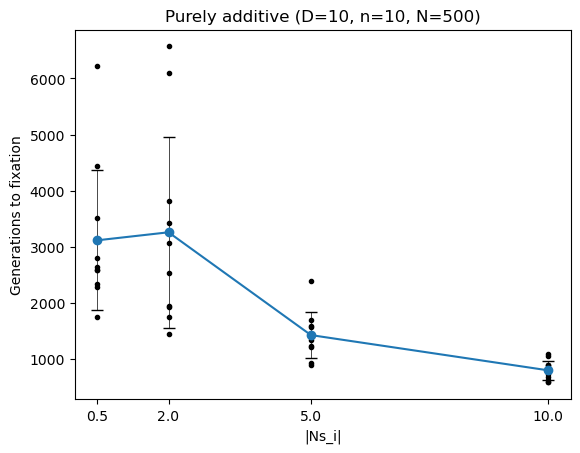

In [17]:
plt.errorbar(Ns,t_add500,yerr=t_err_add500,fmt='o-',ecolor='k',elinewidth=0.5, capsize=4)
plt.plot(Ns,[t_si05_add500,t_si2_add500,t_si5_add500,t_si10_add500],'ko',ms=3)
plt.title('Purely additive (D=10, n=10, N=500)')
plt.xlabel('|Ns_i|')
plt.ylabel('Generations to fixation')
plt.xticks(Ns)
plt.show()

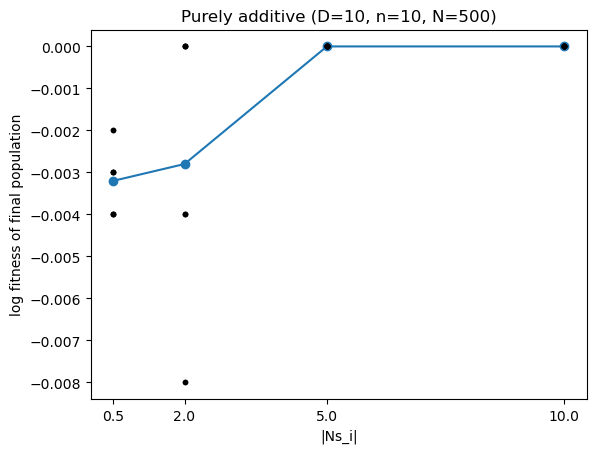

In [18]:
plt.plot(Ns,lgfit_add500,'o-')
plt.plot(Ns,[lgfit_si05_add500,lgfit_si2_add500,lgfit_si5_add500,lgfit_si10_add500],'ko',ms=3)
plt.title('Purely additive (D=10, n=10, N=500)')
plt.xlabel('|Ns_i|')
plt.ylabel('log fitness of final population')
plt.xticks(Ns)
plt.show()

# Maximum epistasis (positive)
All a_ij have same sign.

In [19]:
n = 10; D = 10; N = 500
D_h = int(D/2)
si_target = 0.5
r = np.sqrt(si_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")
#print(f"target N|s| = {4*r**2*D*N}") # not true in this case
print('')

r_list = np.full([D,1],r)
A = np.concatenate((r_list,np.zeros([D,n-1])),axis=1)
zP1 = np.concatenate((np.full([1,N],-2*D_h*r),np.zeros([n-1,N])))

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)

G_an_lf = np.log(fitness_val(G_an,A.T,zP1,O))
print(f"Ancestor has log fitness: {G_an_lf[0]}")
P1_lf = np.log(fitness_val(P1,A.T,zP1,O))
print(f"P1 has log fitness: {P1_lf[0]}")
P2_lf = np.log(fitness_val(P2,A.T,zP1,O))
print(f"P2 has log fitness: {P2_lf[0]}")

repeats = 10
t = []; H = []; lgfit = []
for k in range(1,repeats+1):
    print('')
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    t.append(w[1])
    H.append(w[2])
    lgfit.append(w[3])
    #print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")
print(f't{t}\nH{H}\nlgfit {lgfit}')
t_si05_epi500 = t
H_si05_epi500 = H
lgfit_si05_epi500 = lgfit

r = 0.015811388300841896
target s_i =-0.0009999999999999998
target N|s_i| = 0.4999999999999999

Ancestor has log fitness: 0.0
P1 has log fitness: -0.024999999999999942
P2 has log fitness: -0.024999999999999942

Simulation 1
no. of generations to fixation 1428
hybridisation index (H)0.7
log fitness of final population -0.003999999999999988

Simulation 2
no. of generations to fixation 3222
hybridisation index (H)0.3
log fitness of final population -0.003999999999999988

Simulation 3
no. of generations to fixation 2674
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 4
no. of generations to fixation 1463
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 5
no. of generations to fixation 4301
hybridisation index (H)0.4
log fitness of final population -0.0009999999999999697

Simulation 6
no. of generations to fixation 2687
hybridisation index (H)0.4
log fitness of final population -0.0009999999999999697

Simulation 7
no. of generations to fi

In [20]:
n = 10; D = 10; N = 500
D_h = int(D/2)
si_target = 2
r = np.sqrt(si_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")
#print(f"target N|s| = {4*r**2*D*N}") # not true in this case
print('')

r_list = np.full([D,1],r)
A = np.concatenate((r_list,np.zeros([D,n-1])),axis=1)
zP1 = np.concatenate((np.full([1,N],-2*D_h*r),np.zeros([n-1,N])))

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)

G_an_lf = np.log(fitness_val(G_an,A.T,zP1,O))
print(f"Ancestor has log fitness: {G_an_lf[0]}")
P1_lf = np.log(fitness_val(P1,A.T,zP1,O))
print(f"P1 has log fitness: {P1_lf[0]}")
P2_lf = np.log(fitness_val(P2,A.T,zP1,O))
print(f"P2 has log fitness: {P2_lf[0]}")

repeats = 10
t = []; H = []; lgfit = []
for k in range(1,repeats+1):
    print('')
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    t.append(w[1])
    H.append(w[2])
    lgfit.append(w[3])
    #print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")
print(f't{t}\nH{H}\nlgfit {lgfit}')
t_si2_epi500 = t
H_si2_epi500 = H
lgfit_si2_epi500 = lgfit

r = 0.03162277660168379
target s_i =-0.003999999999999999
target N|s_i| = 1.9999999999999996

Ancestor has log fitness: 0.0
P1 has log fitness: -0.09999999999999994
P2 has log fitness: -0.09999999999999994

Simulation 1
no. of generations to fixation 1505
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 2
no. of generations to fixation 3335
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 3
no. of generations to fixation 2170
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 4
no. of generations to fixation 5079
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 5
no. of generations to fixation 2766
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 6
no. of generations to fixation 1453
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 7
no. of generations to fixation 2390
hybridisation index (H)0.5
log fitness of final population 0.0

Si

In [21]:
n = 10; D = 10; N = 500
D_h = int(D/2)
si_target = 5
r = np.sqrt(si_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")
#print(f"target N|s| = {4*r**2*D*N}") # not true in this case
print('')

r_list = np.full([D,1],r)
A = np.concatenate((r_list,np.zeros([D,n-1])),axis=1)
zP1 = np.concatenate((np.full([1,N],-2*D_h*r),np.zeros([n-1,N])))

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)

G_an_lf = np.log(fitness_val(G_an,A.T,zP1,O))
print(f"Ancestor has log fitness: {G_an_lf[0]}")
P1_lf = np.log(fitness_val(P1,A.T,zP1,O))
print(f"P1 has log fitness: {P1_lf[0]}")
P2_lf = np.log(fitness_val(P2,A.T,zP1,O))
print(f"P2 has log fitness: {P2_lf[0]}")

repeats = 10
t = []; H = []; lgfit = []
for k in range(1,repeats+1):
    print('')
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    t.append(w[1])
    H.append(w[2])
    lgfit.append(w[3])
    #print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")
print(f't{t}\nH{H}\nlgfit {lgfit}')
t_si5_epi500 = t
H_si5_epi500 = H
lgfit_si5_epi500 = lgfit

r = 0.05
target s_i =-0.010000000000000002
target N|s_i| = 5.000000000000001

Ancestor has log fitness: 0.0
P1 has log fitness: -0.25
P2 has log fitness: -0.24999999999999983

Simulation 1
no. of generations to fixation 2044
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 2
no. of generations to fixation 1491
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 3
no. of generations to fixation 2276
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 4
no. of generations to fixation 1250
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 5
no. of generations to fixation 1721
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 6
no. of generations to fixation 1036
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 7
no. of generations to fixation 2644
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 8
no. of generations t

In [22]:
n = 10; D = 10; N = 500
D_h = int(D/2)
si_target = 10
r = np.sqrt(si_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")
#print(f"target N|s| = {4*r**2*D*N}") # not true in this case
print('')

r_list = np.full([D,1],r)
A = np.concatenate((r_list,np.zeros([D,n-1])),axis=1)
zP1 = np.concatenate((np.full([1,N],-2*D_h*r),np.zeros([n-1,N])))

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)

G_an_lf = np.log(fitness_val(G_an,A.T,zP1,O))
print(f"Ancestor has log fitness: {G_an_lf[0]}")
P1_lf = np.log(fitness_val(P1,A.T,zP1,O))
print(f"P1 has log fitness: {P1_lf[0]}")
P2_lf = np.log(fitness_val(P2,A.T,zP1,O))
print(f"P2 has log fitness: {P2_lf[0]}")

repeats = 10
t = []; H = []; lgfit = []
for k in range(1,repeats+1):
    print('')
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    t.append(w[1])
    H.append(w[2])
    lgfit.append(w[3])
    #print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")
print(f't{t}\nH{H}\nlgfit {lgfit}')
t_si10_epi500 = t
H_si10_epi500 = H
lgfit_si10_epi500 = lgfit

r = 0.07071067811865475
target s_i =-0.02
target N|s_i| = 10.0

Ancestor has log fitness: 0.0
P1 has log fitness: -0.49999999999999983
P2 has log fitness: -0.4999999999999996

Simulation 1
no. of generations to fixation 1849
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 2
no. of generations to fixation 1353
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 3
no. of generations to fixation 1002
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 4
no. of generations to fixation 1472
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 5
no. of generations to fixation 1508
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 6
no. of generations to fixation 1966
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 7
no. of generations to fixation 2325
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 8
no. of generations t

In [46]:
#plots
Ns = [0.5,2,5,10]
t_epi500 = [np.mean(t_si05_epi500),np.mean(t_si2_epi500),np.mean(t_si5_epi500),np.mean(t_si10_epi500)]
t_err_epi500 = [np.std(t_si05_epi500),np.std(t_si2_epi500),np.std(t_si5_epi500),np.std(t_si10_epi500)]
lgfit_epi500 = [np.mean(lgfit_si05_epi500),np.mean(lgfit_si2_epi500),np.mean(lgfit_si5_epi500),np.mean(lgfit_si10_epi500)]
lgfit_err_epi500 = [np.std(lgfit_si05_epi500),np.std(lgfit_si2_epi500),np.std(lgfit_si5_epi500),np.std(lgfit_si10_epi500)]

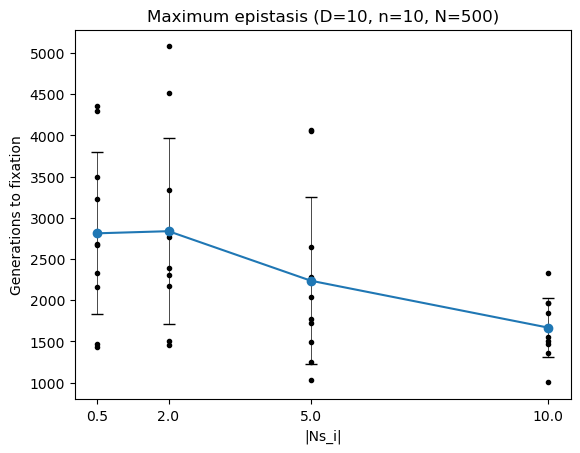

In [24]:
plt.errorbar(Ns,t_epi500,yerr=t_err_epi500,fmt='o-',ecolor='k',elinewidth=0.5, capsize=4)
plt.plot(Ns,[t_si05_epi500,t_si2_epi500,t_si5_epi500,t_si10_epi500],'ko',ms=3)
plt.title('Maximum epistasis (D=10, n=10, N=500)')
plt.xlabel('|Ns_i|')
plt.ylabel('Generations to fixation')
plt.xticks(Ns)
plt.show()

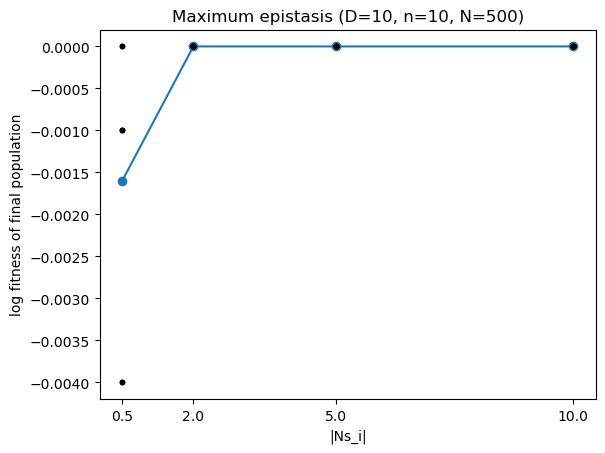

In [25]:
plt.plot(Ns,lgfit_epi500,'o-')
plt.plot(Ns,[lgfit_si05_epi500,lgfit_si2_epi500,lgfit_si5_epi500,lgfit_si10_epi500],'ko',ms=3)
plt.title('Maximum epistasis (D=10, n=10, N=500)')
plt.xlabel('|Ns_i|')
plt.ylabel('log fitness of final population')
plt.xticks(Ns)
plt.show()

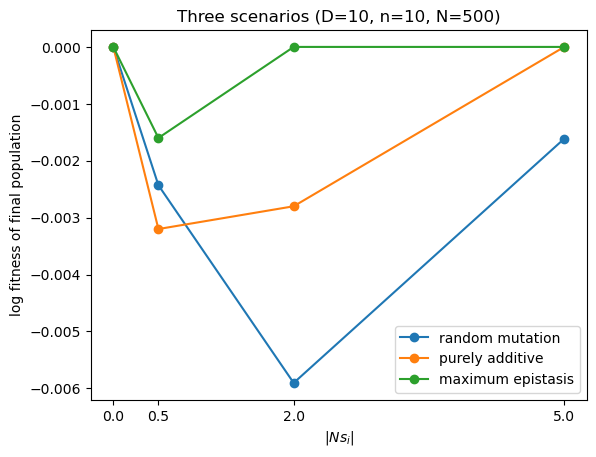

In [60]:
Ns = [0,0.5,2,5]
plt.plot(Ns,[0,lgfit_ran500[0],lgfit_ran500[1],lgfit_ran500[2]],'o-')
plt.plot(Ns,[0,lgfit_add500[0],lgfit_add500[1],lgfit_add500[2]],'o-')
plt.plot(Ns,[0,lgfit_epi500[0],lgfit_epi500[1],lgfit_epi500[2]],'o-')
#plt.plot(Ns,[lgfit_si05_add500,lgfit_si2_add500,lgfit_si5_add500,lgfit_si10_add500],'ko',ms=3)
plt.title('Three scenarios (D=10, n=10, N=500)')
plt.xlabel(r'$|Ns_i|$')
plt.ylabel('log fitness of final population')
plt.legend(['random mutation','purely additive','maximum epistasis'])
plt.xticks(Ns)
plt.show()

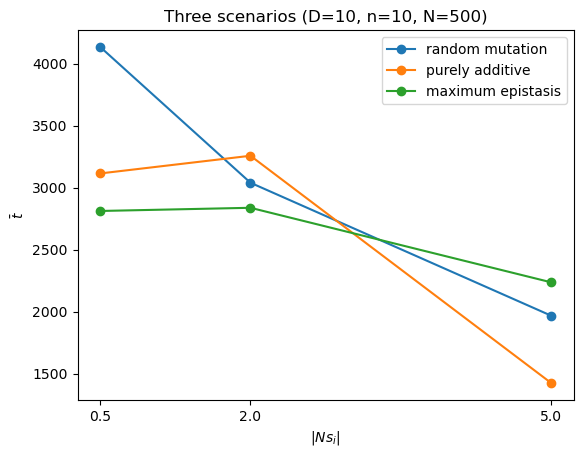

In [62]:
Ns = [0.5,2,5]
plt.plot(Ns,t_ran500[:3],'o-')
plt.plot(Ns,t_add500[:3],'o-')
plt.plot(Ns,t_epi500[:3],'o-')
#plt.plot(Ns,[lgfit_si05_add500,lgfit_si2_add500,lgfit_si5_add500,lgfit_si10_add500],'ko',ms=3)
plt.title('Three scenarios (D=10, n=10, N=500)')
plt.xlabel(r'$|Ns_i|$')
plt.ylabel(r'$\bar{t}$')
plt.legend(['random mutation','purely additive','maximum epistasis'])
plt.xticks(Ns)
plt.show()

# Repeat the three scenarios with N=50
to show that the pattern and turning point still holds with different sizes of N, so that in subsequent simulations we can feel safe about using N=50

## Random mutation

In [28]:
# random mutation
rng = np.random.default_rng(seed=214)

n = 10; D = 10; N = 50
#choose scaling factor so that N*|s|~5
s_i_target = 0.5
r = np.sqrt(s_i_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| ～ {4*r**2*N}")

D_h = int(D/2)

m = rng.normal(loc=0,scale=1,size=[D_h,n])
l = rng.normal(loc=0,scale=1,size=[D_h,n])
M = scaling(r,m,D_h,n)
L = scaling(r,l,D_h,n)

zP1_vec = 2*np.sum(M,axis=0)
zP1 = np.reshape(np.repeat(zP1_vec,repeats=N,axis=0),newshape=[n,N])

A = np.concatenate((-1*M,L),axis=0)

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)
P1_log_fit = np.log(fitness_val(P1,A.T,zP1,O))
P2_log_fit = np.log(fitness_val(P2,A.T,zP1,O))
print(f"log fitness of P1 is {P1_log_fit[0]}")
print(f"log fitness of P2 is {P2_log_fit[0]}")

repeats = 50
t = []; H = []; lgfit = []
for k in range(1,repeats+1):
    print('')
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    t.append(w[1])
    H.append(w[2])
    lgfit.append(w[3])
    #print(f"final population {w[0]}")
    #print(f"no. of generations to fixation {w[1]}")
    #print(f"hybridisation index (H){w[2]}")
    #print(f"log fitness of final population {w[3]}")
print(f't{t}\nH{H}\nlgfit {lgfit}')
t_si05_ran50 = t
H_si05_ran50 = H
lgfit_si05_ran50 = lgfit

r = 0.05
target s_i =-0.010000000000000002
target N|s_i| ～ 0.5000000000000001
log fitness of P1 is -0.0926749434143179
log fitness of P2 is -0.051555426415887395

Simulation 1

Simulation 2

Simulation 3

Simulation 4

Simulation 5

Simulation 6

Simulation 7

Simulation 8

Simulation 9

Simulation 10

Simulation 11

Simulation 12

Simulation 13

Simulation 14

Simulation 15

Simulation 16

Simulation 17

Simulation 18

Simulation 19

Simulation 20

Simulation 21

Simulation 22

Simulation 23

Simulation 24

Simulation 25

Simulation 26

Simulation 27

Simulation 28

Simulation 29

Simulation 30

Simulation 31

Simulation 32

Simulation 33

Simulation 34

Simulation 35

Simulation 36

Simulation 37

Simulation 38

Simulation 39

Simulation 40

Simulation 41

Simulation 42

Simulation 43

Simulation 44

Simulation 45

Simulation 46

Simulation 47

Simulation 48

Simulation 49

Simulation 50
t[234, 193, 262, 240, 196, 321, 399, 357, 779, 273, 236, 236, 369, 515, 441, 325, 372, 592, 574, 

In [29]:
rng = np.random.default_rng(seed=214)

n = 10; D = 10; N = 50
#choose scaling factor so that N*|s|~5
s_i_target = 2
r = np.sqrt(s_i_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| ～ {4*r**2*N}")

D_h = int(D/2)
# generate normally distributed random numbers for mutations. m for P1 and l for P2. Standard normal distribution.
m = rng.normal(loc=0,scale=1,size=[D_h,n])
l = rng.normal(loc=0,scale=1,size=[D_h,n])
M = scaling(r,m,D_h,n)
L = scaling(r,l,D_h,n)

zP1_vec = 2*np.sum(M,axis=0)
zP1 = np.reshape(np.repeat(zP1_vec,repeats=N,axis=0),newshape=[n,N])
A = np.concatenate((-1*M,L),axis=0)

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)
P1_log_fit = np.log(fitness_val(P1,A.T,zP1,O))
P2_log_fit = np.log(fitness_val(P2,A.T,zP1,O))
print(f"log fitness of P1 is {P1_log_fit[0]}")
print(f"log fitness of P2 is {P2_log_fit[0]}")

repeats = 50
t = []; H = []; lgfit = []
for k in range(1,repeats+1):
    print('')
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    t.append(w[1])
    H.append(w[2])
    lgfit.append(w[3])
    #print(f"final population {w[0]}")
    #print(f"no. of generations to fixation {w[1]}")
    #print(f"hybridisation index (H){w[2]}")
    #print(f"log fitness of final population {w[3]}")
print(f't{t}\nH{H}\nlgfit {lgfit}')
t_si2_ran50 = t
H_si2_ran50 = H
lgfit_si2_ran50 = lgfit

r = 0.1
target s_i =-0.04000000000000001
target N|s_i| ～ 2.0000000000000004
log fitness of P1 is -0.37069977365727175
log fitness of P2 is -0.20622170566354944

Simulation 1

Simulation 2

Simulation 3

Simulation 4

Simulation 5

Simulation 6

Simulation 7

Simulation 8

Simulation 9

Simulation 10

Simulation 11

Simulation 12

Simulation 13

Simulation 14

Simulation 15

Simulation 16

Simulation 17

Simulation 18

Simulation 19

Simulation 20

Simulation 21

Simulation 22

Simulation 23

Simulation 24

Simulation 25

Simulation 26

Simulation 27

Simulation 28

Simulation 29

Simulation 30

Simulation 31

Simulation 32

Simulation 33

Simulation 34

Simulation 35

Simulation 36

Simulation 37

Simulation 38

Simulation 39

Simulation 40

Simulation 41

Simulation 42

Simulation 43

Simulation 44

Simulation 45

Simulation 46

Simulation 47

Simulation 48

Simulation 49

Simulation 50
t[188, 253, 395, 336, 218, 398, 247, 375, 294, 646, 125, 347, 351, 266, 427, 496, 204, 440, 343, 57

In [30]:
rng = np.random.default_rng(seed=214)

n = 10; D = 10; N = 50
#choose scaling factor so that N*|s|~5
s_i_target = 5
r = np.sqrt(s_i_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| ～ {4*r**2*N}")

D_h = int(D/2)
# generate normally distributed random numbers for mutations. m for P1 and l for P2. Standard normal distribution.
m = rng.normal(loc=0,scale=1,size=[D_h,n])
l = rng.normal(loc=0,scale=1,size=[D_h,n])

M = scaling(r,m,D_h,n)
L = scaling(r,l,D_h,n)

zP1_vec = 2*np.sum(M,axis=0)
#print(zP1_vec)
zP1 = np.reshape(np.repeat(zP1_vec,repeats=N,axis=0),newshape=[n,N])
#print(zP1.shape)

A = np.concatenate((-1*M,L),axis=0)
#print(f"A\n{A}")
#print(A.shape)

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)
P1_log_fit = np.log(fitness_val(P1,A.T,zP1,O))
P2_log_fit = np.log(fitness_val(P2,A.T,zP1,O))
print(f"log fitness of P1 is {P1_log_fit[0]}")
print(f"log fitness of P2 is {P2_log_fit[0]}")

repeats = 50
t = []; H = []; lgfit = []
for k in range(1,repeats+1):
    print('')
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    t.append(w[1])
    H.append(w[2])
    lgfit.append(w[3])
    #print(f"final population {w[0]}")
    #print(f"no. of generations to fixation {w[1]}")
    #print(f"hybridisation index (H){w[2]}")
    #print(f"log fitness of final population {w[3]}")
print(f't{t}\nH{H}\nlgfit {lgfit}')
t_si5_ran50 = t
H_si5_ran50 = H
lgfit_si5_ran50 = lgfit

r = 0.15811388300841897
target s_i =-0.1
target N|s_i| ～ 5.0
log fitness of P1 is -0.9267494341431792
log fitness of P2 is -0.5155542641588735

Simulation 1

Simulation 2

Simulation 3

Simulation 4

Simulation 5

Simulation 6

Simulation 7

Simulation 8

Simulation 9

Simulation 10

Simulation 11

Simulation 12

Simulation 13

Simulation 14

Simulation 15

Simulation 16

Simulation 17

Simulation 18

Simulation 19

Simulation 20

Simulation 21

Simulation 22

Simulation 23

Simulation 24

Simulation 25

Simulation 26

Simulation 27

Simulation 28

Simulation 29

Simulation 30

Simulation 31

Simulation 32

Simulation 33

Simulation 34

Simulation 35

Simulation 36

Simulation 37

Simulation 38

Simulation 39

Simulation 40

Simulation 41

Simulation 42

Simulation 43

Simulation 44

Simulation 45

Simulation 46

Simulation 47

Simulation 48

Simulation 49

Simulation 50
t[113, 227, 125, 171, 234, 212, 135, 198, 201, 201, 460, 106, 196, 168, 777, 105, 940, 147, 205, 149, 162, 222, 338,

## Purely additive

In [31]:
n = 10; D = 10; N = 50

si_target = 0.5
r = np.sqrt(si_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")
print('')

D_h = int(D/2)
r_list = np.concatenate((np.full([1,D_h],1*r),np.full([1,D_h],r)))
A = np.diagflat(r_list)
zP1 = np.concatenate((np.full([D_h,N],-2*r),np.zeros([D_h,N])))

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)

G_an_lf = np.log(fitness_val(G_an,A.T,zP1,O))
print(f"Ancestor has log fitness: {G_an_lf[0]}")
P1_lf = np.log(fitness_val(P1,A.T,zP1,O))
print(f"P1 has log fitness: {P1_lf[0]}")
P2_lf = np.log(fitness_val(P2,A.T,zP1,O))
print(f"P2 has log fitness: {P2_lf[0]}")

repeats = 50
t = []; H = []; lgfit = []
for k in range(1,repeats+1):
    print('')
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    t.append(w[1])
    H.append(w[2])
    lgfit.append(w[3])

print(f't{t}\nH{H}\nlgfit {lgfit}')
t_si05_add50 = t
H_si05_add50 = H
lgfit_si05_add50 = lgfit

r = 0.05
target s_i =-0.010000000000000002
target N|s_i| = 0.5000000000000001

Ancestor has log fitness: 0.0
P1 has log fitness: -0.049999999999999996
P2 has log fitness: -0.049999999999999996

Simulation 1

Simulation 2

Simulation 3

Simulation 4

Simulation 5

Simulation 6

Simulation 7

Simulation 8

Simulation 9

Simulation 10

Simulation 11

Simulation 12

Simulation 13

Simulation 14

Simulation 15

Simulation 16

Simulation 17

Simulation 18

Simulation 19

Simulation 20

Simulation 21

Simulation 22

Simulation 23

Simulation 24

Simulation 25

Simulation 26

Simulation 27

Simulation 28

Simulation 29

Simulation 30

Simulation 31

Simulation 32

Simulation 33

Simulation 34

Simulation 35

Simulation 36

Simulation 37

Simulation 38

Simulation 39

Simulation 40

Simulation 41

Simulation 42

Simulation 43

Simulation 44

Simulation 45

Simulation 46

Simulation 47

Simulation 48

Simulation 49

Simulation 50
t[254, 508, 229, 256, 298, 258, 364, 331, 174, 314, 171, 498, 371,

In [32]:
n = 10; D = 10; N = 50

si_target = 2
r = np.sqrt(si_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")
print('')

D_h = int(D/2)
r_list = np.concatenate((np.full([1,D_h],1*r),np.full([1,D_h],r)))
A = np.diagflat(r_list)
zP1 = np.concatenate((np.full([D_h,N],-2*r),np.zeros([D_h,N])))

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)

G_an_lf = np.log(fitness_val(G_an,A.T,zP1,O))
print(f"Ancestor has log fitness: {G_an_lf[0]}")
P1_lf = np.log(fitness_val(P1,A.T,zP1,O))
print(f"P1 has log fitness: {P1_lf[0]}")
P2_lf = np.log(fitness_val(P2,A.T,zP1,O))
print(f"P2 has log fitness: {P2_lf[0]}")

repeats = 50
t = []; H = []; lgfit = []
for k in range(1,repeats+1):
    print('')
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    t.append(w[1])
    H.append(w[2])
    lgfit.append(w[3])

print(f't{t}\nH{H}\nlgfit {lgfit}')
t_si2_add50 = t
H_si2_add50 = H
lgfit_si2_add50 = lgfit

r = 0.1
target s_i =-0.04000000000000001
target N|s_i| = 2.0000000000000004

Ancestor has log fitness: 0.0
P1 has log fitness: -0.20000000000000004
P2 has log fitness: -0.20000000000000004

Simulation 1

Simulation 2

Simulation 3

Simulation 4

Simulation 5

Simulation 6

Simulation 7

Simulation 8

Simulation 9

Simulation 10

Simulation 11

Simulation 12

Simulation 13

Simulation 14

Simulation 15

Simulation 16

Simulation 17

Simulation 18

Simulation 19

Simulation 20

Simulation 21

Simulation 22

Simulation 23

Simulation 24

Simulation 25

Simulation 26

Simulation 27

Simulation 28

Simulation 29

Simulation 30

Simulation 31

Simulation 32

Simulation 33

Simulation 34

Simulation 35

Simulation 36

Simulation 37

Simulation 38

Simulation 39

Simulation 40

Simulation 41

Simulation 42

Simulation 43

Simulation 44

Simulation 45

Simulation 46

Simulation 47

Simulation 48

Simulation 49

Simulation 50
t[376, 280, 297, 209, 206, 338, 346, 263, 264, 212, 304, 555, 300, 300

In [33]:
n = 10; D = 10; N = 50

si_target = 5
r = np.sqrt(si_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")
print('')

D_h = int(D/2)
r_list = np.concatenate((np.full([1,D_h],1*r),np.full([1,D_h],r)))
A = np.diagflat(r_list)


zP1 = np.concatenate((np.full([D_h,N],-2*r),np.zeros([D_h,N])))

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)

G_an_lf = np.log(fitness_val(G_an,A.T,zP1,O))
print(f"Ancestor has log fitness: {G_an_lf[0]}")
P1_lf = np.log(fitness_val(P1,A.T,zP1,O))
print(f"P1 has log fitness: {P1_lf[0]}")
P2_lf = np.log(fitness_val(P2,A.T,zP1,O))
print(f"P2 has log fitness: {P2_lf[0]}")

n = 10; D = 10; N = 50

si_target = 0.5
r = np.sqrt(si_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")
print('')

D_h = int(D/2)
r_list = np.concatenate((np.full([1,D_h],1*r),np.full([1,D_h],r)))
A = np.diagflat(r_list)
zP1 = np.concatenate((np.full([D_h,N],-2*r),np.zeros([D_h,N])))

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)

G_an_lf = np.log(fitness_val(G_an,A.T,zP1,O))
print(f"Ancestor has log fitness: {G_an_lf[0]}")
P1_lf = np.log(fitness_val(P1,A.T,zP1,O))
print(f"P1 has log fitness: {P1_lf[0]}")
P2_lf = np.log(fitness_val(P2,A.T,zP1,O))
print(f"P2 has log fitness: {P2_lf[0]}")

repeats = 50
t = []; H = []; lgfit = []
for k in range(1,repeats+1):
    print('')
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    t.append(w[1])
    H.append(w[2])
    lgfit.append(w[3])

print(f't{t}\nH{H}\nlgfit {lgfit}')
t_si5_add50 = t
H_si5_add50 = H
lgfit_si5_add50 = lgfit

r = 0.15811388300841897
target s_i =-0.1
target N|s_i| = 5.0

Ancestor has log fitness: 0.0
P1 has log fitness: -0.5
P2 has log fitness: -0.5
r = 0.05
target s_i =-0.010000000000000002
target N|s_i| = 0.5000000000000001

Ancestor has log fitness: 0.0
P1 has log fitness: -0.049999999999999996
P2 has log fitness: -0.049999999999999996

Simulation 1

Simulation 2

Simulation 3

Simulation 4

Simulation 5

Simulation 6

Simulation 7

Simulation 8

Simulation 9

Simulation 10

Simulation 11

Simulation 12

Simulation 13

Simulation 14

Simulation 15

Simulation 16

Simulation 17

Simulation 18

Simulation 19

Simulation 20

Simulation 21

Simulation 22

Simulation 23

Simulation 24

Simulation 25

Simulation 26

Simulation 27

Simulation 28

Simulation 29

Simulation 30

Simulation 31

Simulation 32

Simulation 33

Simulation 34

Simulation 35

Simulation 36

Simulation 37

Simulation 38

Simulation 39

Simulation 40

Simulation 41

Simulation 42

Simulation 43

Simulation 44

Simulation 45

## Maximum epistasis

In [34]:
n = 10; D = 10; N = 50
D_h = int(D/2)
si_target = 0.5
r = np.sqrt(si_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")
#print(f"target N|s| = {4*r**2*D*N}") # not true in this case
print('')

r_list = np.full([D,1],r)
A = np.concatenate((r_list,np.zeros([D,n-1])),axis=1)
zP1 = np.concatenate((np.full([1,N],-2*D_h*r),np.zeros([n-1,N])))

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)

G_an_lf = np.log(fitness_val(G_an,A.T,zP1,O))
print(f"Ancestor has log fitness: {G_an_lf[0]}")
P1_lf = np.log(fitness_val(P1,A.T,zP1,O))
print(f"P1 has log fitness: {P1_lf[0]}")
P2_lf = np.log(fitness_val(P2,A.T,zP1,O))
print(f"P2 has log fitness: {P2_lf[0]}")

n = 10; D = 10; N = 50

si_target = 0.5
r = np.sqrt(si_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")
print('')

D_h = int(D/2)
r_list = np.concatenate((np.full([1,D_h],1*r),np.full([1,D_h],r)))
A = np.diagflat(r_list)
zP1 = np.concatenate((np.full([D_h,N],-2*r),np.zeros([D_h,N])))

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)

G_an_lf = np.log(fitness_val(G_an,A.T,zP1,O))
print(f"Ancestor has log fitness: {G_an_lf[0]}")
P1_lf = np.log(fitness_val(P1,A.T,zP1,O))
print(f"P1 has log fitness: {P1_lf[0]}")
P2_lf = np.log(fitness_val(P2,A.T,zP1,O))
print(f"P2 has log fitness: {P2_lf[0]}")

repeats = 50
t = []; H = []; lgfit = []
for k in range(1,repeats+1):
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    t.append(w[1])
    H.append(w[2])
    lgfit.append(w[3])

print(f't{t}\nH{H}\nlgfit {lgfit}')
t_si05_epi50 = t
H_si05_epi50 = H
lgfit_si05_epi50 = lgfit

r = 0.05
target s_i =-0.010000000000000002
target N|s_i| = 0.5000000000000001

Ancestor has log fitness: 0.0
P1 has log fitness: -0.25
P2 has log fitness: -0.24999999999999983
r = 0.05
target s_i =-0.010000000000000002
target N|s_i| = 0.5000000000000001

Ancestor has log fitness: 0.0
P1 has log fitness: -0.049999999999999996
P2 has log fitness: -0.049999999999999996
t[396, 317, 518, 680, 224, 299, 592, 302, 422, 352, 535, 262, 212, 353, 315, 638, 244, 377, 229, 302, 244, 360, 285, 199, 202, 370, 430, 331, 279, 336, 344, 279, 371, 371, 198, 294, 302, 356, 166, 256, 278, 329, 353, 343, 294, 356, 397, 148, 485, 208]
H[0.5, 0.3, 0.6, 0.6, 0.7, 0.2, 0.8, 0.5, 0.3, 0.7, 0.6, 0.3, 0.4, 0.5, 0.4, 0.3, 0.4, 0.5, 0.3, 0.5, 0.4, 0.5, 0.4, 0.7, 0.7, 0.7, 0.5, 0.5, 0.4, 0.5, 0.5, 0.5, 0.7, 0.6, 0.6, 0.6, 0.598, 0.3, 0.4, 0.3, 0.5, 0.5, 0.4, 0.4, 0.6, 0.7, 0.6, 0.3, 0.5, 0.4]
lgfit [-0.02000000000000005, -0.040000000000000036, -0.030000000000000023, -0.030000000000000023, -0.040000000000000036, -0.0

In [35]:
n = 10; D = 10; N = 50
D_h = int(D/2)
si_target = 2
r = np.sqrt(si_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")
#print(f"target N|s| = {4*r**2*D*N}") # not true in this case
print('')

r_list = np.full([D,1],r)
A = np.concatenate((r_list,np.zeros([D,n-1])),axis=1)
zP1 = np.concatenate((np.full([1,N],-2*D_h*r),np.zeros([n-1,N])))

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)

G_an_lf = np.log(fitness_val(G_an,A.T,zP1,O))
print(f"Ancestor has log fitness: {G_an_lf[0]}")
P1_lf = np.log(fitness_val(P1,A.T,zP1,O))
print(f"P1 has log fitness: {P1_lf[0]}")
P2_lf = np.log(fitness_val(P2,A.T,zP1,O))
print(f"P2 has log fitness: {P2_lf[0]}")

n = 10; D = 10; N = 50

si_target = 0.5
r = np.sqrt(si_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")
print('')

D_h = int(D/2)
r_list = np.concatenate((np.full([1,D_h],1*r),np.full([1,D_h],r)))
A = np.diagflat(r_list)
zP1 = np.concatenate((np.full([D_h,N],-2*r),np.zeros([D_h,N])))

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)

G_an_lf = np.log(fitness_val(G_an,A.T,zP1,O))
print(f"Ancestor has log fitness: {G_an_lf[0]}")
P1_lf = np.log(fitness_val(P1,A.T,zP1,O))
print(f"P1 has log fitness: {P1_lf[0]}")
P2_lf = np.log(fitness_val(P2,A.T,zP1,O))
print(f"P2 has log fitness: {P2_lf[0]}")

repeats = 50
t = []; H = []; lgfit = []
for k in range(1,repeats+1):
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    t.append(w[1])
    H.append(w[2])
    lgfit.append(w[3])

print(f't{t}\nH{H}\nlgfit {lgfit}')
t_si2_epi50 = t
H_si2_epi50 = H
lgfit_si2_epi50 = lgfit

r = 0.1
target s_i =-0.04000000000000001
target N|s_i| = 2.0000000000000004

Ancestor has log fitness: 0.0
P1 has log fitness: -1.0
P2 has log fitness: -0.9999999999999996
r = 0.05
target s_i =-0.010000000000000002
target N|s_i| = 0.5000000000000001

Ancestor has log fitness: 0.0
P1 has log fitness: -0.049999999999999996
P2 has log fitness: -0.049999999999999996
t[850, 458, 312, 213, 491, 303, 368, 518, 236, 510, 405, 244, 299, 132, 176, 322, 380, 203, 373, 198, 362, 273, 269, 297, 330, 262, 385, 453, 372, 170, 321, 474, 245, 231, 349, 305, 208, 519, 281, 317, 124, 352, 243, 209, 749, 420, 184, 646, 391, 283]
H[0.7, 0.5, 0.5, 0.5, 0.5, 0.3, 0.5, 0.3, 0.5, 0.6, 0.4, 0.5, 0.5, 0.7, 0.5, 0.7, 0.5, 0.5, 0.1, 0.5, 0.8, 0.4, 0.6, 0.7, 0.5, 0.1, 0.7, 0.5, 0.7, 0.6, 0.6, 0.3, 0.4, 0.8, 0.5, 0.6, 0.3, 1.0, 0.3, 0.2, 0.5, 0.8, 0.5, 0.7, 0.4, 0.5, 0.3, 0.5, 0.3, 0.502]
lgfit [-0.02000000000000005, -0.040000000000000036, -0.02000000000000005, -0.05999999999999999, -0.02000000000000005, -0.04000000

In [36]:
n = 10; D = 10; N = 50
D_h = int(D/2)
si_target = 5
r = np.sqrt(si_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")
#print(f"target N|s| = {4*r**2*D*N}") # not true in this case
print('')

r_list = np.full([D,1],r)
A = np.concatenate((r_list,np.zeros([D,n-1])),axis=1)
zP1 = np.concatenate((np.full([1,N],-2*D_h*r),np.zeros([n-1,N])))

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)

G_an_lf = np.log(fitness_val(G_an,A.T,zP1,O))
print(f"Ancestor has log fitness: {G_an_lf[0]}")
P1_lf = np.log(fitness_val(P1,A.T,zP1,O))
print(f"P1 has log fitness: {P1_lf[0]}")
P2_lf = np.log(fitness_val(P2,A.T,zP1,O))
print(f"P2 has log fitness: {P2_lf[0]}")

repeats = 50
t = []; H = []; lgfit = []
for k in range(1,repeats+1):
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    t.append(w[1])
    H.append(w[2])
    lgfit.append(w[3])

print(f't{t}\nH{H}\nlgfit {lgfit}')
t_si5_epi50 = t
H_si5_epi50 = H
lgfit_si5_epi50 = lgfit

r = 0.15811388300841897
target s_i =-0.1
target N|s_i| = 5.0

Ancestor has log fitness: 0.0
P1 has log fitness: -2.5000000000000004
P2 has log fitness: -2.5000000000000004
t[366, 168, 277, 270, 272, 279, 559, 278, 217, 205, 140, 268, 117, 180, 225, 182, 113, 285, 203, 254, 168, 273, 212, 147, 177, 284, 224, 215, 193, 422, 216, 279, 249, 378, 197, 409, 264, 258, 201, 210, 91, 189, 222, 186, 163, 185, 288, 388, 386, 320]
H[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
lgfit [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [37]:
n = 10; D = 10; N = 50
D_h = int(D/2)
si_target = 10
r = np.sqrt(si_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")
#print(f"target N|s| = {4*r**2*D*N}") # not true in this case
print('')

r_list = np.full([D,1],r)
A = np.concatenate((r_list,np.zeros([D,n-1])),axis=1)
zP1 = np.concatenate((np.full([1,N],-2*D_h*r),np.zeros([n-1,N])))

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)

G_an_lf = np.log(fitness_val(G_an,A.T,zP1,O))
print(f"Ancestor has log fitness: {G_an_lf[0]}")
P1_lf = np.log(fitness_val(P1,A.T,zP1,O))
print(f"P1 has log fitness: {P1_lf[0]}")
P2_lf = np.log(fitness_val(P2,A.T,zP1,O))
print(f"P2 has log fitness: {P2_lf[0]}")

repeats = 50
t = []; H = []; lgfit = []
for k in range(1,repeats+1):
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    t.append(w[1])
    H.append(w[2])
    lgfit.append(w[3])

print(f't{t}\nH{H}\nlgfit {lgfit}')
t_si10_epi50 = t
H_si10_epi50 = H
lgfit_si10_epi50 = lgfit

r = 0.22360679774997896
target s_i =-0.19999999999999998
target N|s_i| = 10.0

Ancestor has log fitness: 0.0
P1 has log fitness: -5.000000000000001
P2 has log fitness: -5.000000000000001
t[260, 167, 216, 201, 164, 245, 356, 348, 155, 264, 142, 116, 269, 186, 269, 158, 153, 135, 184, 208, 229, 197, 134, 130, 151, 224, 146, 105, 165, 118, 225, 138, 199, 148, 236, 224, 152, 91, 204, 163, 161, 233, 177, 195, 147, 99, 153, 308, 132, 255]
H[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
lgfit [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [38]:
Ns = [0.5,2,5]
t_ran50 = [np.mean(t_si05_ran50),np.mean(t_si2_ran50),np.mean(t_si5_ran50)]
t_err_ran50 = [np.std(t_si05_ran50),np.std(t_si2_ran50),np.std(t_si5_ran50)]
lgfit_ran50 = [np.mean(lgfit_si05_ran50),np.mean(lgfit_si2_ran50),np.mean(lgfit_si5_ran50)]
lgfit_err_ran50 = [np.std(lgfit_si05_ran50),np.std(lgfit_si2_ran50),np.std(lgfit_si5_ran50)]

t_add50 = [np.mean(t_si05_add50),np.mean(t_si2_add50),np.mean(t_si5_add50)]
t_err_add50 = [np.std(t_si05_add50),np.std(t_si2_add50),np.std(t_si5_add50)]
lgfit_add50 = [np.mean(lgfit_si05_add50),np.mean(lgfit_si2_add50),np.mean(lgfit_si5_add50)]
lgfit_err_add50 = [np.std(lgfit_si05_add50),np.std(lgfit_si2_add50),np.std(lgfit_si5_add50)]

t_epi50 = [np.mean(t_si05_epi50),np.mean(t_si2_epi50),np.mean(t_si5_epi50)]
t_err_epi50 = [np.std(t_si05_epi50),np.std(t_si2_epi50),np.std(t_si5_epi50)]
lgfit_epi50 = [np.mean(lgfit_si05_epi50),np.mean(lgfit_si2_epi50),np.mean(lgfit_si5_epi50)]
lgfit_err_epi50 = [np.std(lgfit_si05_epi50),np.std(lgfit_si2_epi50),np.std(lgfit_si5_epi50)]

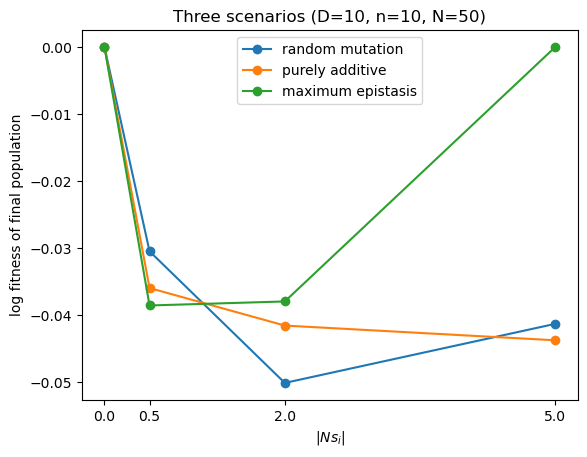

In [51]:
Ns = [0,0.5,2,5]
plt.plot(Ns,[0,lgfit_ran50[0],lgfit_ran50[1],lgfit_ran50[2]],'o-')
plt.plot(Ns,[0,lgfit_add50[0],lgfit_add50[1],lgfit_add50[2]],'o-')
plt.plot(Ns,[0,lgfit_epi50[0],lgfit_epi50[1],lgfit_epi50[2]],'o-')
#plt.plot(Ns,[lgfit_si05_add500,lgfit_si2_add500,lgfit_si5_add500,lgfit_si10_add500],'ko',ms=3)
plt.title('Three scenarios (D=10, n=10, N=50)')
plt.xlabel(r'$|Ns_i|$')
plt.ylabel('log fitness of final population')
plt.legend(['random mutation','purely additive','maximum epistasis'])
plt.xticks(Ns)
plt.show()

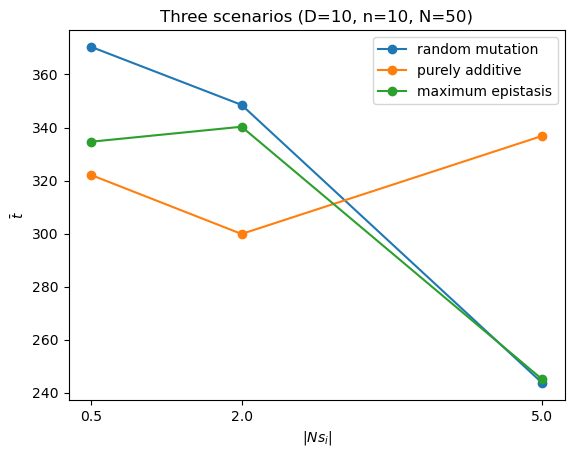

In [59]:
Ns = [0.5,2,5]
plt.plot(Ns,t_ran50,'o-')
plt.plot(Ns,t_add50,'o-')
plt.plot(Ns,t_epi50,'o-')
#plt.plot(Ns,[lgfit_si05_add500,lgfit_si2_add500,lgfit_si5_add500,lgfit_si10_add500],'ko',ms=3)
plt.title('Three scenarios (D=10, n=10, N=50)')
plt.xlabel(r'$|Ns_i|$')
plt.ylabel(r'$\bar{t}$')
plt.legend(['random mutation','purely additive','maximum epistasis'])
plt.xticks(Ns)
plt.show()

# Varying D/n ratio
The examples above all have D/n = 1. We now try D/n = 10 and 0.1, using the random mutation model only.

In [41]:
# random mutation
rng = np.random.default_rng(seed=214)

n = 10; D = 100; N = 50
#choose scaling factor so that N*|s|~5
s_i_target = 5
r = np.sqrt(s_i_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| ～ {4*r**2*N}")

D_h = int(D/2)
# generate normally distributed random numbers for mutations. m for P1 and l for P2. Standard normal distribution.
m = rng.normal(loc=0,scale=1,size=[D_h,n])
l = rng.normal(loc=0,scale=1,size=[D_h,n])

M = scaling(r,m,D_h,n)
L = scaling(r,l,D_h,n)

zP1_vec = 2*np.sum(M,axis=0)
#print(zP1_vec)
zP1 = np.reshape(np.repeat(zP1_vec,repeats=N,axis=0),newshape=[n,N])
#print(zP1.shape)

A = np.concatenate((-1*M,L),axis=0)
#print(f"A\n{A}")
#print(A.shape)

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)
P1_log_fit = np.log(fitness_val(P1,A.T,zP1,O))
P2_log_fit = np.log(fitness_val(P2,A.T,zP1,O))
print(f"log fitness of P1 is {P1_log_fit[0]}")
print(f"log fitness of P2 is {P2_log_fit[0]}")
lgfit = []
repeats = 50
for k in range(1,repeats+1):
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    #print(f"final population {w[0]}")
    #print(f"no. of generations to fixation {w[1]}")
    #print(f"hybridisation index (H){w[2]}")
    #print(f"log fitness of final population {w[3]}")
    lgfit.append(w[3])
lgfit_dn10 = lgfit

r = 0.15811388300841897
target s_i =-0.1
target N|s_i| ～ 5.0
log fitness of P1 is -4.032034809695836
log fitness of P2 is -4.594271225404893
Simulation 1
Simulation 2
Simulation 3
Simulation 4
Simulation 5
Simulation 6
Simulation 7
Simulation 8
Simulation 9
Simulation 10
Simulation 11
Simulation 12
Simulation 13
Simulation 14
Simulation 15
Simulation 16
Simulation 17
Simulation 18
Simulation 19
Simulation 20
Simulation 21
Simulation 22
Simulation 23
Simulation 24
Simulation 25
Simulation 26
Simulation 27
Simulation 28
Simulation 29
Simulation 30
Simulation 31
Simulation 32
Simulation 33
Simulation 34
Simulation 35
Simulation 36
Simulation 37
Simulation 38
Simulation 39
Simulation 40
Simulation 41
Simulation 42
Simulation 43
Simulation 44
Simulation 45
Simulation 46
Simulation 47
Simulation 48
Simulation 49
Simulation 50


In [42]:
# random mutation
rng = np.random.default_rng(seed=214)

n = 100; D = 10; N = 50
#choose scaling factor so that N*|s|~5
s_i_target = 5
r = np.sqrt(s_i_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| ～ {4*r**2*N}")

D_h = int(D/2)
# generate normally distributed random numbers for mutations. m for P1 and l for P2. Standard normal distribution.
m = rng.normal(loc=0,scale=1,size=[D_h,n])
l = rng.normal(loc=0,scale=1,size=[D_h,n])

M = scaling(r,m,D_h,n)
L = scaling(r,l,D_h,n)

zP1_vec = 2*np.sum(M,axis=0)
#print(zP1_vec)
zP1 = np.reshape(np.repeat(zP1_vec,repeats=N,axis=0),newshape=[n,N])
#print(zP1.shape)

A = np.concatenate((-1*M,L),axis=0)
#print(f"A\n{A}")
#print(A.shape)

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)
P1_log_fit = np.log(fitness_val(P1,A.T,zP1,O))
P2_log_fit = np.log(fitness_val(P2,A.T,zP1,O))
print(f"log fitness of P1 is {P1_log_fit[0]}")
print(f"log fitness of P2 is {P2_log_fit[0]}")

lgfit = []
repeats = 50
for k in range(1,repeats+1):
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    #print(f"final population {w[0]}")
    #print(f"no. of generations to fixation {w[1]}")
    #print(f"hybridisation index (H){w[2]}")
    #print(f"log fitness of final population {w[3]}")
    lgfit.append(w[3])
lgfit_dn01 = lgfit

r = 0.15811388300841897
target s_i =-0.1
target N|s_i| ～ 5.0
log fitness of P1 is -0.5481963121553212
log fitness of P2 is -0.5117682725475692
Simulation 1
Simulation 2
Simulation 3
Simulation 4
Simulation 5
Simulation 6
Simulation 7
Simulation 8
Simulation 9
Simulation 10
Simulation 11
Simulation 12
Simulation 13
Simulation 14
Simulation 15
Simulation 16
Simulation 17
Simulation 18
Simulation 19
Simulation 20
Simulation 21
Simulation 22
Simulation 23
Simulation 24
Simulation 25
Simulation 26
Simulation 27
Simulation 28
Simulation 29
Simulation 30
Simulation 31
Simulation 32
Simulation 33
Simulation 34
Simulation 35
Simulation 36
Simulation 37
Simulation 38
Simulation 39
Simulation 40
Simulation 41
Simulation 42
Simulation 43
Simulation 44
Simulation 45
Simulation 46
Simulation 47
Simulation 48
Simulation 49
Simulation 50


In [68]:
print(lgfit_dn01)
print(len(np.unique(lgfit_dn10)))
print(lgfit_dn10)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.10000000000000006, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.10000000000000006, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.09999999999999994, 0.0, 0.0]
50
[-0.06635692860978804, -0.05679545587368692, -0.09464164287727213, -0.08023356502215898, -0.12195007011071253, -0.04341609083388986, -0.22133859639312511, -0.039356323660666236, -0.15639502361555083, -0.12931894893084367, -0.05043913667603162, -0.09853905210716617, -0.10102689679596155, -0.07822876837307158, -0.06790901019857755, -0.11328339751628096, -0.10260704281311803, -0.07354678584885023, -0.061107013867116804, -0.12157269011650616, -0.07093267431634444, -0.08020495433721067, -0.05818683548410704, -0.05259344433857007, -0.021838647431141583, -0.07594315792906894, -0.049487428111658203, -0.12313401090709739, -0.07845527189487826, -0.05732723638384879, -0.09125822666854126, -0.06489

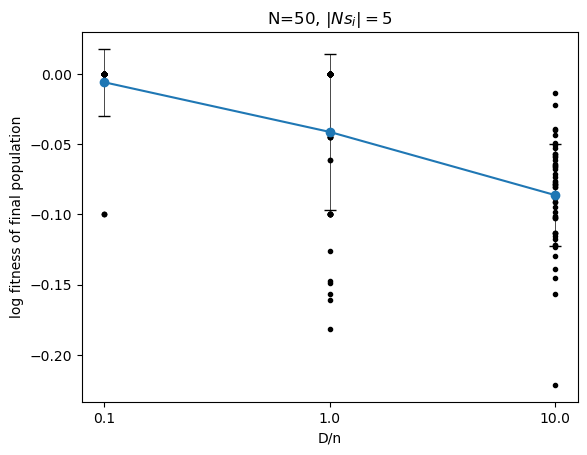

In [63]:
dn =['0.1','1.0','10.0']
lgfit_dn_mean = [np.mean(lgfit_dn01),lgfit_ran50[2],np.mean(lgfit_dn10)]
lgfit_dn_err = [np.std(lgfit_dn01),lgfit_err_ran50[2],np.std(lgfit_dn10)]
plt.errorbar(dn,lgfit_dn_mean,yerr=lgfit_dn_err,fmt='o-',ecolor='k',elinewidth=0.5, capsize=4)

plt.plot(dn,[lgfit_dn01,lgfit_si5_ran50,lgfit_dn10],'ko',ms=3)
plt.title(r'N=50, $|Ns_i|=5$')
plt.xlabel('D/n')
plt.ylabel('log fitness of final population')
nN = -1*[]
plt.show()